In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [ ]:
!pip install geopandas
#!pip install uszipcode

     |████████████████████████████████| 1.0MB 2.9MB/s 
     |████████████████████████████████| 15.4MB 356kB/s 
     |████████████████████████████████| 6.6MB 39.2MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning/divvy_data/data/stations.csv')
df = df.drop(columns='Unnamed: 0')
df['lat'] = df['coord'].map(lambda x: x.split(',')[0]).astype(float)
df['long'] = df['coord'].map(lambda x: x.split(',')[1]).astype(float)

In [ ]:
df.columns

Index(['station_name', 'total_count', 'start_count', 'end_count',
       'end_percent', 'coord', 'classic_bike_p', 'ebike_p', 'casual_p',
       'weekend_p', 'morning_p', 'evening_p', 'average_distance',
       'var_distance', 'lat', 'long', 'zipcode', 'population_density',
       'housing_occupancy_rate', 'median_household_income',
       'average_home_value', 'black_p', 'asian_p', 'latinx_p', 'white_p',
       'age18_29_p', 'age30_39_p', 'age40_49_p', 'age50_59_p', 'age65_p',
       'num_bike_stations', 'num_phys_crime', 'num_wc_crime',
       'min_dis_rail_station', 'num_bus_stop'],
      dtype='object')

# postal code and population density (2010 Census data)

https://pypi.org/project/uszipcode/

uszipcode source code on data source: https://github.com/MacHu-GWU/uszipcode-project/blob/master/uszipcode/db.py

In [ ]:
from uszipcode import Zipcode
from uszipcode import SearchEngine
search = SearchEngine(simple_zipcode=True)

In [ ]:
df['zipcode'] = np.nan
df['population_density'] = np.nan
df['housing_occupancy_rate'] = np.nan
df['median_household_income'] = np.nan
for i in df.index:
  result = search.by_coordinates(df.loc[i, 'lat'],df.loc[i, 'long'], radius=5, returns=1)
  df.loc[i, 'zipcode'] = int(result[0].zipcode)
  df.loc[i, 'population_density'] = result[0].population_density
  df.loc[i, 'housing_occupancy_rate'] = result[0].occupied_housing_units/result[0].housing_units
  df.loc[i, 'median_household_income'] = result[0].median_household_income

#home Price (Zillow)

https://www.zillow.com/research/data/

Homevalues

In [ ]:
dfp = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning/divvy_data/data/home_price.csv')
dfp = dfp[dfp['City']=='Chicago']
dfp = dfp[['RegionName', '2021-04-30']]
dfp = dfp.set_index('RegionName')
dfp_dic = dfp.to_dict('dict')
dfp_dic = dfp_dic['2021-04-30']

In [ ]:
df['average_home_value'] = np.nan
df['average_home_value'] = df['zipcode'].map(dfp_dic)

# demography by zipcode

https://data.cityofchicago.org/Health-Human-Services/Chicago-Population-Counts/85cm-7uqa

In [ ]:
dfd = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning/divvy_data/data/Chicago_Population_Counts.csv')

In [ ]:
#age groups
dfd['age18_29_p'] = dfd['Population - Age 18-29']/dfd['Population - Total']
dfd['age30_39_p'] = dfd['Population - Age 30-39']/dfd['Population - Total']
dfd['age40_49_p'] = dfd['Population - Age 40-49']/dfd['Population - Total']
dfd['age50_59_p'] = dfd['Population - Age 50-59']/dfd['Population - Total']
dfd['age65_p'] = dfd['Population - Age 65+']/dfd['Population - Total']

#racial groups
dfd['black_p'] = dfd['Population - Black Non-Latinx']/dfd['Population - Total']
dfd['asian_p'] = dfd['Population - Asian Non-Latinx']/dfd['Population - Total']
dfd['latinx_p'] = dfd['Population - Latinx']/dfd['Population - Total']
dfd['white_p'] = dfd['Population - White Non-Latinx']/dfd['Population - Total']

In [ ]:
dfd.columns

Index(['Geography Type', 'Year', 'Geography', 'Population - Total',
       'Population - Age 0-17', 'Population - Age 18-29',
       'Population - Age 30-39', 'Population - Age 40-49',
       'Population - Age 50-59', 'Population - Age 60-69',
       'Population - Age 70-79', 'Population - Age 80+',
       'Population - Age 18+', 'Population - Age 65+', 'Population - Female',
       'Population - Male', 'Population - Latinx',
       'Population - Asian Non-Latinx', 'Population - Black Non-Latinx',
       'Population - White Non-Latinx', 'Population - Other Race Non-Latinx',
       'Record ID', 'age18_29_p', 'age30_39_p', 'age40_49_p', 'age50_59_p',
       'age65_p', 'black_p', 'asian_p', 'latinx_p', 'white_p'],
      dtype='object')

In [ ]:
dfd2 = dfd[['Geography', 'black_p', 'asian_p', 'latinx_p', 'white_p', 'age18_29_p', 'age30_39_p', 'age40_49_p', 'age50_59_p','age65_p']]

In [ ]:
df['zipcode'] = df['zipcode'].astype(int)
df = df.merge(dfd2, how='left', left_on='zipcode', right_on='Geography')
df = df.drop(columns=['Geography'])

# station density

In [ ]:
def count_bike_stations(dflong, dflat):
  counts = -1
  for i in df.index:
    long_dis = abs(df.loc[i, 'long'] - dflong)
    lat_dis = abs(df.loc[i, 'lat'] - dflat)
    if (long_dis <= 0.008) and (lat_dis <= 0.008): #800m in longtide and latitude
      counts += 1
  return counts

In [ ]:
df['num_bike_stations'] = 0
for i in df.index:
  df.loc[i, 'num_bike_stations'] = count_bike_stations(df.loc[i, 'long'], df.loc[i, 'lat'])

# import crime data

https://data.cityofchicago.org/Public-Safety/Crimes-2020/qzdf-xmn8

In [3]:
dfc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning/divvy_data/data/Crimes_2020.csv')
dfc['month'] = dfc['Date'].map(lambda x: x[:2])

In [4]:
top10 = dfc['Primary Type'].value_counts().head(10).sort_values()

In [ ]:
top10

ROBBERY                 7855
WEAPONS VIOLATION       8425
BURGLARY                8734
MOTOR VEHICLE THEFT     9938
OTHER OFFENSE          12518
DECEPTIVE PRACTICE     17636
ASSAULT                18242
CRIMINAL DAMAGE        24856
THEFT                  41169
BATTERY                41463
Name: Primary Type, dtype: int64

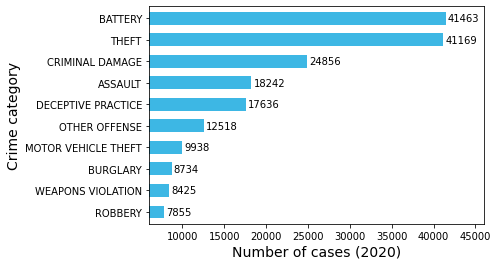

In [15]:
f,ax=plt.subplots(figsize=(6,4))
top10.plot.barh(width=0.6, color='#3DB7E4')
ax.set_xlabel('Number of cases (2020)', fontsize=14)
ax.set_ylabel('Crime category', fontsize=14)
ax.set_xlim(6000, 46000)

rects = ax.patches
for rect in rects:
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2
    space = 2
    ha = 'left'

    if x_value < 0:
        space *= -1
        ha = 'right'

    label = int(x_value)

    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha=ha)                      # Horizontally align label differently for
  
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Deep Learning/divvy_data/figures/p2a.png', dpi=150, bbox_inches='tight')

In [ ]:
#physical crime
dfcp = dfc[dfc['month']=='04']
dfcp = dfcp[dfcp['Primary Type'] !='DECEPTIVE PRACTICE']

In [ ]:
def count_pcrime(dflong, dflat):
  counts = 0
  for i in dfcp.index:
    long_dis = abs(dfcp.loc[i, 'Longitude'] - dflong)
    lat_dis = abs(dfcp.loc[i, 'Latitude'] - dflat)
    if (long_dis <= 0.004) and (lat_dis <= 0.004): #400 meters in longtide and latitude
      counts += 1
  return counts

In [ ]:
df['num_phys_crime'] = 0
for i in df.index:
  df.loc[i, 'num_phys_crime'] = count_pcrime(df.loc[i, 'long'], df.loc[i, 'lat'])

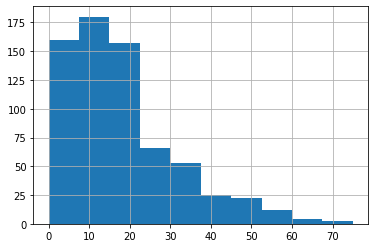

In [ ]:
df['num_phys_crime'].hist()

In [ ]:
#white collar crime
dfcw = dfc[dfc['Primary Type'] =='DECEPTIVE PRACTICE']

In [ ]:
def count_wcrime(dflong, dflat):
  counts = 0
  for i in dfcw.index:
    long_dis = abs(dfcw.loc[i, 'Longitude'] - dflong)
    lat_dis = abs(dfcw.loc[i, 'Latitude'] - dflat)
    if (long_dis <= 0.004) and (lat_dis <= 0.004): #400 meters in longtide and latitude
      counts += 1
  return counts

In [ ]:
df['num_wc_crime'] = 0
for i in df.index:
  df.loc[i, 'num_wc_crime'] = count_wcrime(df.loc[i, 'long'], df.loc[i, 'lat'])

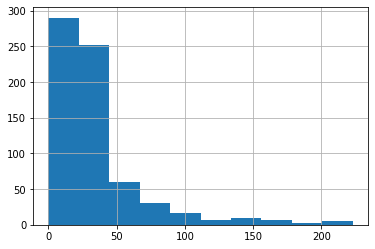

In [ ]:
df['num_wc_crime'].hist()

# import CTA rail station

https://data.cityofchicago.org/Transportation/CTA-L-Rail-Stations-kml/4qtv-9w43

In [ ]:
import geopandas as gpd
import fiona

In [ ]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
dfr = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Deep Learning/divvy_data/data/CTA_RailStations.kml', driver='KML')

In [ ]:
dfr.shape

(144, 3)

In [ ]:
dfr['long'] = dfr['geometry'].map(lambda x: str(x).split('(')[1].split(' ')[0]).astype(float)
dfr['lat'] = dfr['geometry'].map(lambda x: str(x).split('(')[1].split(' ')[1]).astype(float)

In [ ]:
def find_min_distance(dflong, dflat):
  dist = []
  for i in dfr.index:
    long_dis = dfr.loc[i, 'long'] - dflong
    lat_dis = dfr.loc[i, 'lat'] - dflat
    dist.append(math.sqrt(long_dis**2 + lat_dis**2))
  return min(dist)

In [ ]:
df['min_dis_rail_station'] = 0
for i in df.index:
  df.loc[i, 'min_dis_rail_station'] = find_min_distance(df.loc[i, 'long'], df.loc[i, 'lat'])

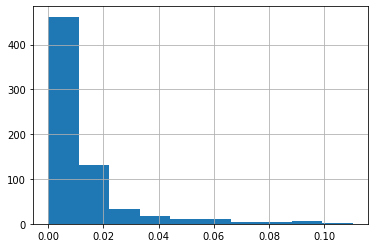

In [ ]:
df['min_dis_rail_station'].hist()

# import CTA bus stop

https://data.cityofchicago.org/Transportation/CTA-Bus-Stops-kml/84eu-buny

In [ ]:
from zipfile import ZipFile

In [ ]:
kmz = ZipFile('/content/drive/MyDrive/Colab Notebooks/Deep Learning/divvy_data/data/CTA_BusStops.kmz', 'r')
kml = kmz.open('doc.kml', 'r')

In [ ]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
dfb = gpd.read_file(kml, driver='KML')

In [ ]:
dfb.shape

(10847, 3)

In [ ]:
dfb['long'] = dfb['geometry'].map(lambda x: str(x).split('(')[1].split(' ')[0]).astype(float)
dfb['lat'] = dfb['geometry'].map(lambda x: str(x).split('(')[1].split(' ')[1]).astype(float)

In [ ]:
def count_stops(dflong, dflat):
  stops = 0
  for i in dfb.index:
    long_dis = abs(dfb.loc[i, 'long'] - dflong)
    lat_dis = abs(dfb.loc[i, 'lat'] - dflat)
    if (long_dis <= 0.002) and (lat_dis <= 0.002): #200 meters in longtide and latitude
      stops += 1
  return stops

In [ ]:
df['num_bus_stop'] = 0
for i in df.index:
  df.loc[i, 'num_bus_stop'] = count_stops(df.loc[i, 'long'], df.loc[i, 'lat'])

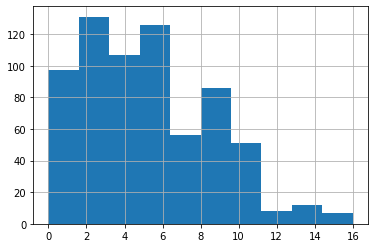

In [ ]:
df['num_bus_stop'].hist()

In [ ]:
#df.to_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning/divvy_data/data/stations2.csv')